# Flatiron School Phase 4 Project

Student name: **Angelo Turri**

Student pace: **self paced**

Project finish date: ****

Instructor name: **Mark Barbour**

Blog post URL: **[x]**

# INTRODUCTION

### Stakeholder



### Data: Origin & Usage



### Methods Justification & Value to Stakeholder



### Limitations



### Model Evaluation



In [232]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output, display_html
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.arima.model import ARIMA
import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('data/zillow_data.csv')

In [4]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.set_index('time', inplace=True)
    return melted

In [5]:
# Changing from wide to long format
df = melt_data(data)

# Making sure each zipcode in the dataset has the full 265 months of data
df['zipcount'] = df['RegionName'].map(df.RegionName.value_counts())
df = df[df.zipcount==265]

# Changing the name of the zipcode column to accurately reflect what it contains.
df['zipcode'] = df['RegionName']
df.drop(['RegionName'], axis=1, inplace=True)

In [6]:
df = df.query("State=='MI'")

In [7]:
ad_2012 = df[df.index>'2011-12-1'].copy()
grouped = ad_2012.groupby('time').aggregate({'value':'mean'})

# General trend of house price data

You can see the effects of the 2008 housing market crash on what was an otherwise ever-increasing series of data points. This crash was an anomaly in the general upward trend of housing prices. I will only keep data after 2012, which is when the housing market slump seemed to be over.

In [8]:
grouped = df.groupby('time').aggregate({'value':'mean'})

<Axes: xlabel='time'>

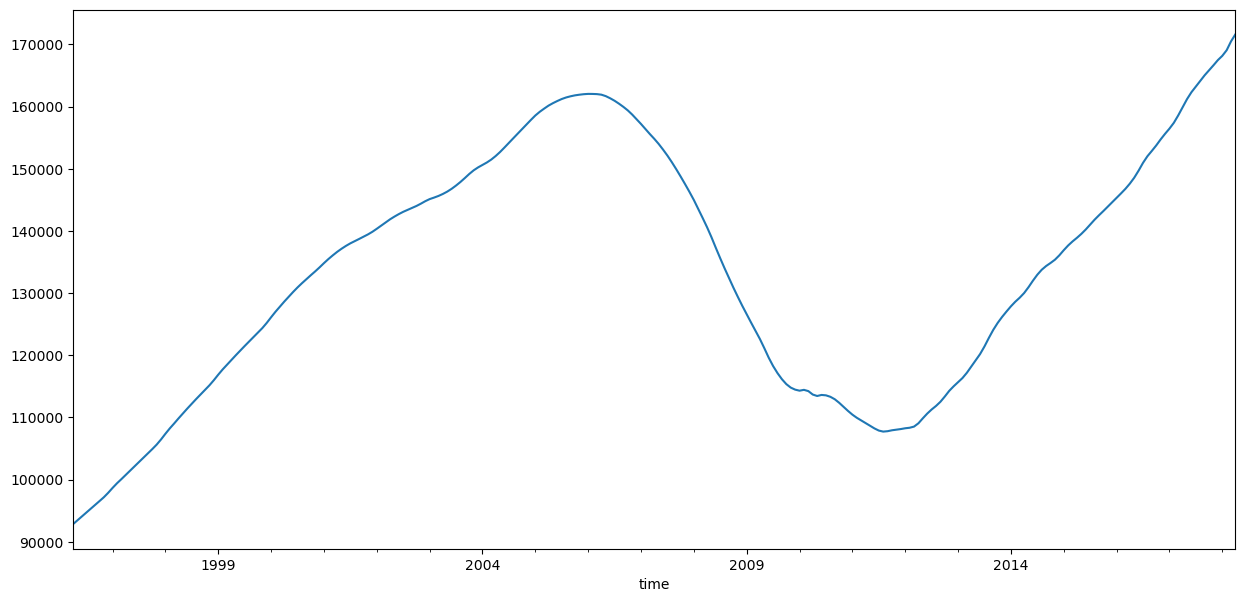

In [9]:
fig, ax = plt.subplots(figsize=(15,7))
grouped.value.plot()

# Data after the housing market crash

As expected, we have removed the anomalous housing market crash and what remains is a normal, linearly trending group of data for housing prices. This is the data that we will use for our models.

In [10]:
# Keeping data during and after 2012
ad_2012 = df[df.index>'2011-12-1'].copy()
grouped = ad_2012.groupby('time').aggregate({'value':'mean'})

<Axes: xlabel='time'>

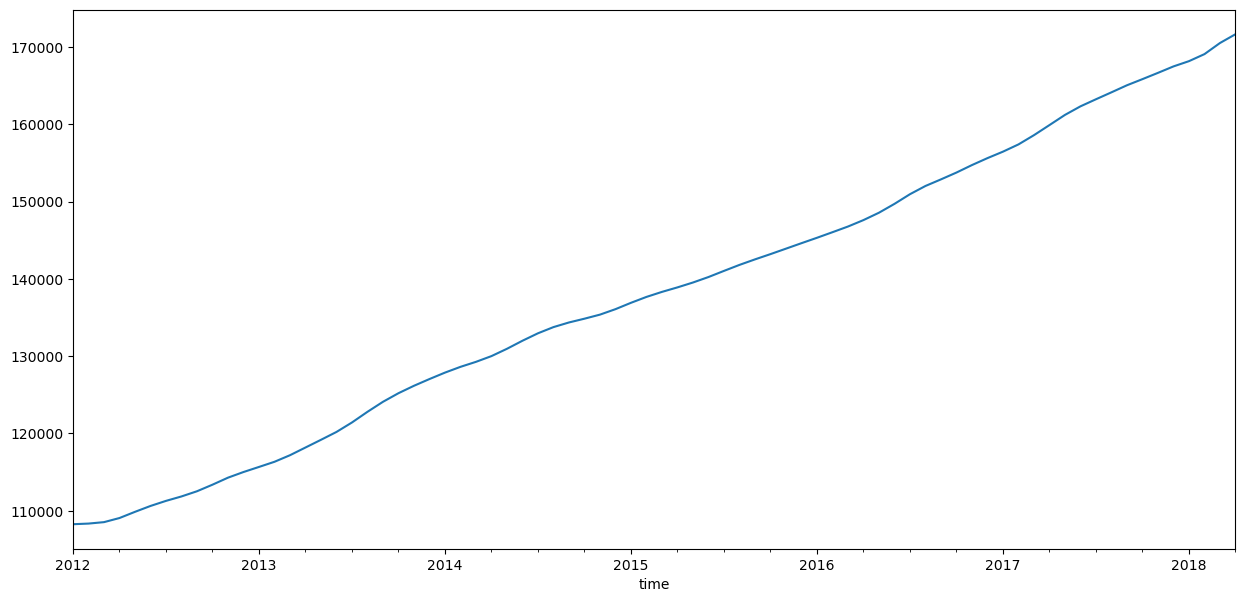

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
grouped.value.plot()

# Number of zipcodes

Our stakeholder wants us to examine all the zipcodes in the dataset. There are 13,684 zipcodes in total, spread out across all 50 states. To find out which zipcodes are the best ones to invest in, we will have to forecast housing prices in each zipcode, which means fitting at least one model to each. ARIMA and SARMIAX do not take categorical exogenous variables, only numerical ones, which excludes the zipcode variable from being included in either type of model.

In [12]:
df.dtypes

RegionID        int64
SizeRank        int64
City           object
State          object
Metro          object
CountyName     object
value         float64
zipcount        int64
zipcode         int64
dtype: object

In [13]:
df.zipcode.nunique()

453

In [14]:
df.State.nunique()

1

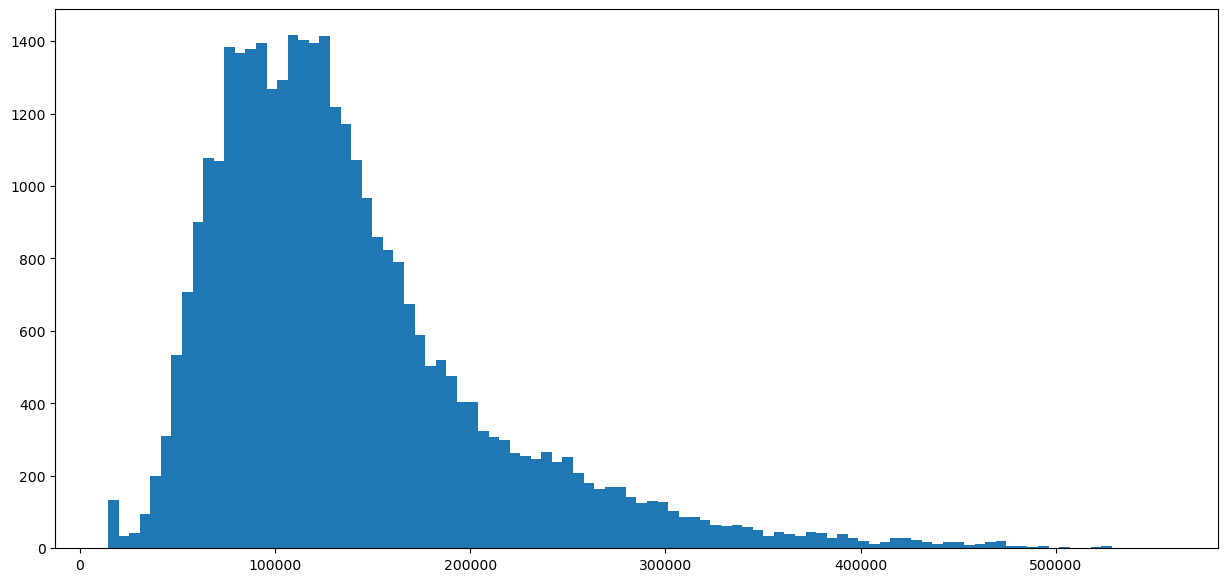

In [15]:
fig, ax = plt.subplots(figsize=(15,7))
ax.hist(ad_2012.value, bins=100);

# Kinds of zipcodes

Although the aggregated dataset shows a clear upwards trend, not all zipcodes follow this pattern. There are zipcodes that follow a very linear upward trajectory, but there are others that follow a more cyclical path. This suggests that there is no one model that will fit well to all the zipcodes.

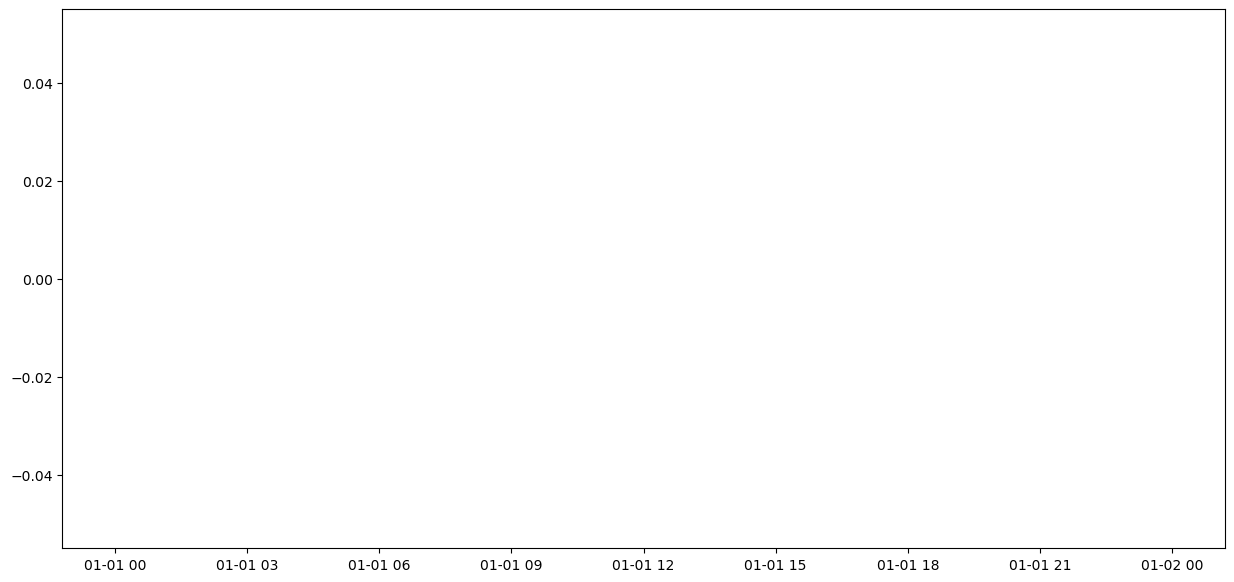

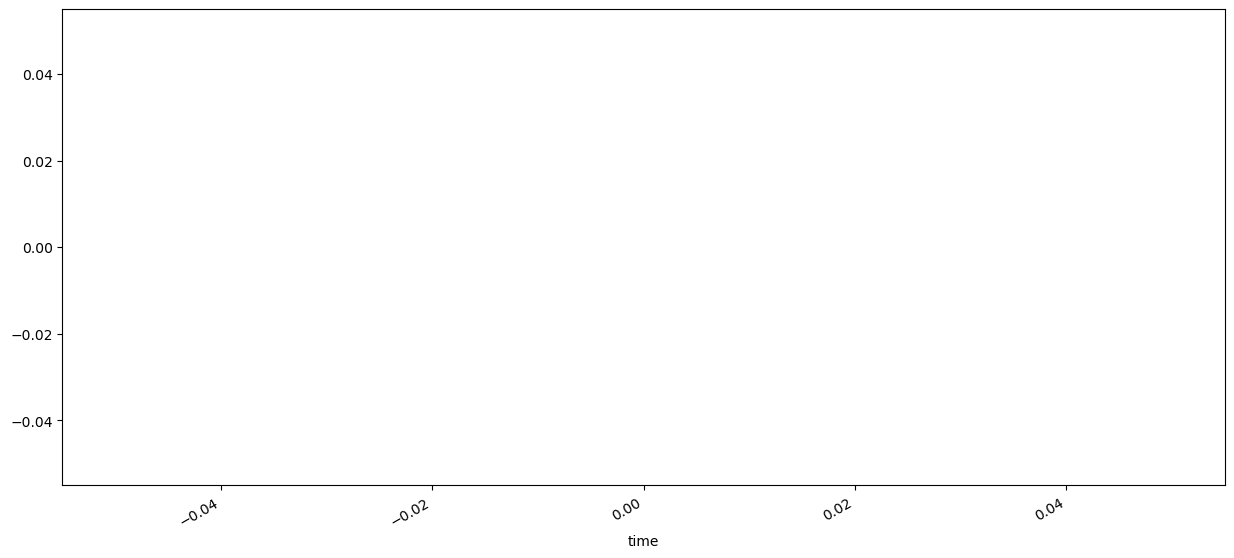

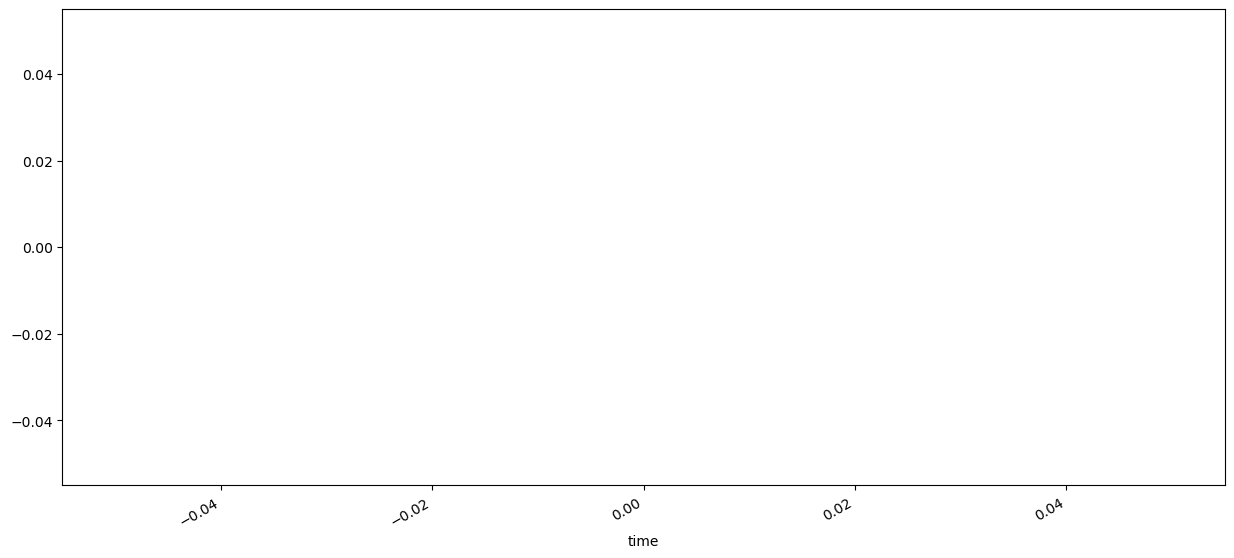

In [16]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(ad_2012[ad_2012.zipcode==18702].value)

fig, ax = plt.subplots(figsize=(15,7))
ad_2012[ad_2012.zipcode==77084].value.plot()

fig, ax = plt.subplots(figsize=(15,7))
ad_2012[ad_2012.zipcode==61611].value.plot();

# Naive Models

The baseline naive model we will use is a model with all values shifted forward by 1.

A successful model will successfully extract all temporal components from each zipcode's time series, and the accompanying model residuals will be stationary.

Only 46% of the models actually reduced their accompanying time series to a white noise model. The average mse of our models was 12.7 million. This will be our benchmark for other models.

In [17]:
st = time.time()

mses = []
ad_pvalues, kpss_pvalues = [], []
residuals_list = []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    zipcode = ad_2012[ad_2012.zipcode==zc].value
    shifted = zipcode.shift(1)[1:]
    
    mse = mean_squared_error(zipcode[1:], shifted)
    mses.append(mse)
    
    residuals = shifted-zipcode[1:]
    residuals_list.append(residuals)
    
    dftest = adfuller(residuals)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    ad_pvalues.append(dfoutput['p-value'])
    
    kpsstest = kpss(residuals, regression='ct')
    kpss_pvalues.append(kpsstest[1])
    
    clear_output(wait=True)
    print(f"Zipcode #{i+1}/{ad_2012.zipcode.nunique()} done.")
    
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode #453/453 done.
Execution time: 1.6119790077209473 seconds


In [18]:
naive_model_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'mse': mses, 
                               'adfuller_pvalue': ad_pvalues, 
                               'kpss_pvalue': kpss_pvalues, 
                               'residuals': residuals_list})

In [19]:
len(naive_model_df.query("adfuller_pvalue<0.05 & kpss_pvalue>0.05"))/len(naive_model_df)

0.5761589403973509

In [20]:
naive_model_df.mse.mean()

2213863.723325975

In [21]:
len(naive_model_df.query("mse>1000000000"))

0

In [22]:
naive_model_df.query("mse<1000000000").mse.mean()

2213863.723325975

<Axes: >

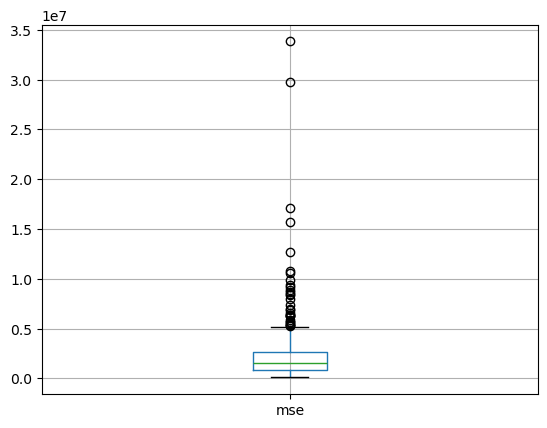

In [23]:
naive_model_df.query("mse<100000000").boxplot(column=['mse'])

# Deciding our parameters for the ARIMA model

Looking at our autocorrelation and partial autocorrelation plots, it looks like we should at least make one difference on the data. Let's perform the difference and then re-evaluate the partial and autocorrelation plots.

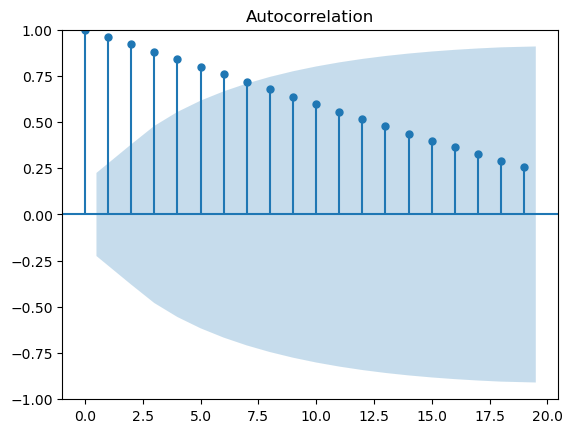

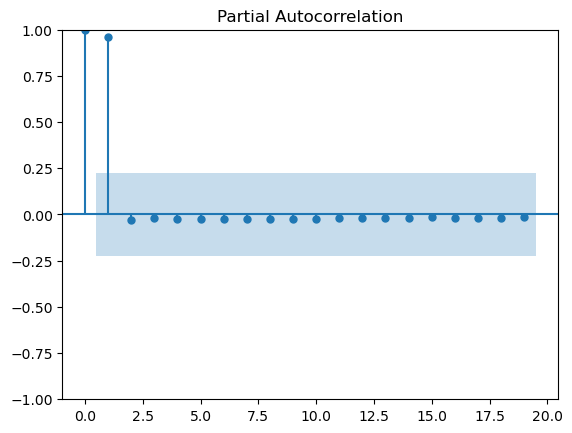

In [24]:
plot_acf(grouped.value);
plot_pacf(grouped.value);

# Differencing the series

After differencing the aggregated series, the number of significant lags went down from 7 to 3, two of which are well outside the significance boundary. Our partial autocorrelation plot remains the same.

These suggest that our first model should have at least two AR terms, one MA term, and one difference.

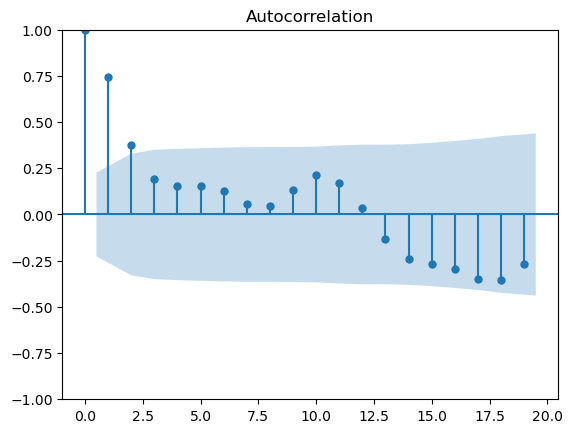

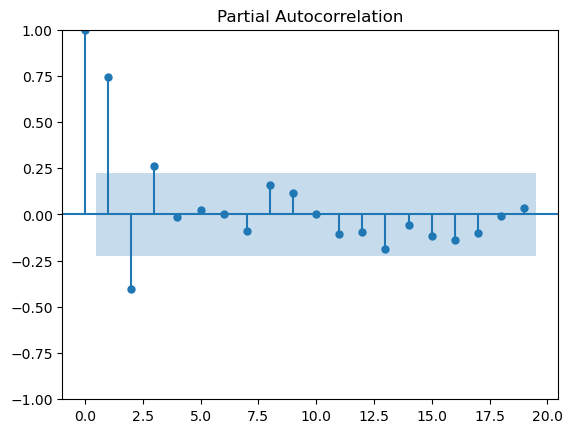

In [25]:
plot_acf(grouped.diff(1).value[1:]);
plot_pacf(grouped.diff(1).value[1:]);

# Running ARIMA models of order (1,1,1)

Using one AR term, one MA term, and one difference per the PACF and ACF plots above.

In [118]:
st = time.time()

predictions_list = []
forecasts = []
original = []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    zipcode = ad_2012[ad_2012.zipcode==zc].value
    original.append(zipcode)
    print(f"Zipcode: {zc}")

    model = ARIMA(zipcode, order=(1, 1, 1)).fit()
            
    predictions = model.predict()
    predictions_list.append(predictions)
    
    forecast = model.get_forecast(steps=28).predicted_mean
    forecasts.append(forecast)
    
    clear_output(wait=True)
    print(f"Zipcode #{i+1}/{ad_2012.zipcode.nunique()} done.")
    
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode #453/453 done.
Execution time: 15.584398031234741 seconds


In [119]:
arima_model_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'predictions': predictions_list, 
                               'forecast': forecasts, 
                               'original': original})

arima_model_df['predictions'] = arima_model_df.predictions.map(lambda x: x[1:])
arima_model_df['original'] = arima_model_df.original.map(lambda x: x[1:])
arima_model_df['residuals'] = [arima_model_df.original.iloc[i] - arima_model_df.predictions.iloc[i] for i in range(len(arima_model_df))]
arima_model_df['mse'] = [mean_squared_error(arima_model_df.original.iloc[i], arima_model_df.predictions.iloc[i]) for i in range(len(arima_model_df))]

def ad_pvalue(dataframe):
    dftest = adfuller(dataframe)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    return dfoutput['p-value']

def kpss_pvalue(dataframe):
    kpsstest = kpss(dataframe, regression='ct')
    return kpsstest[1]

arima_model_df['adfuller_pvalue'] = arima_model_df['residuals'].map(ad_pvalue)
arima_model_df['kpss_pvalue'] = arima_model_df['residuals'].map(kpss_pvalue)

In [120]:
len(arima_model_df.query("adfuller_pvalue<0.05 & kpss_pvalue>0.05"))/len(arima_model_df)

0.6114790286975718

In [121]:
arima_model_df.mse.mean()

1328207.7942073783

In [122]:
len(arima_model_df.query("mse>1000000000"))

0

In [123]:
arima_model_df.query("mse<1000000000").mse.mean()

1328207.7942073783

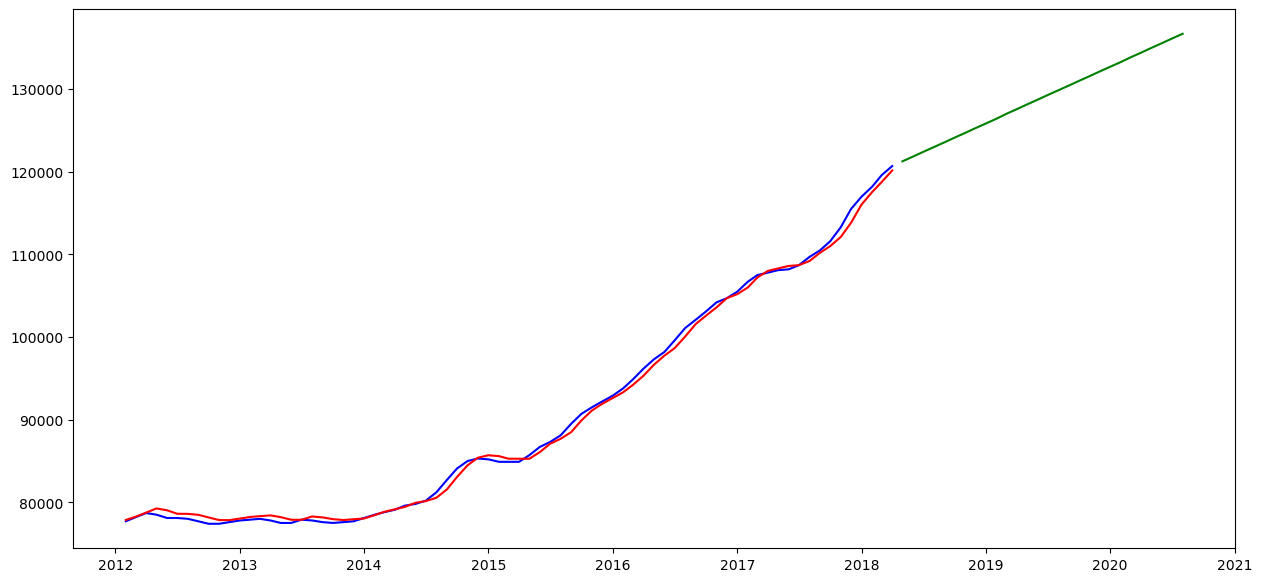

In [124]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(row.original, c='blue', label='original')
ax.plot(row.predictions, c='red', label='predictions')
ax.plot(row.forecast, c='green', label='forecast')

# Train-test split

The models appear to be in working order. However, we have not implemented a train-test split. We will include all years from 2012 – 2017 for the training data, and everything after will be for the test portion of our dataset.

In [193]:
st = time.time()

predictions_list = []
forecasts = []
trains, tests = [], []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    zipcode = ad_2012[ad_2012.zipcode==zc].value
    print(f"Zipcode: {zc}")
    
    train = zipcode[zipcode.index<'2017-01-01']
    test = zipcode[zipcode.index>'2016-12-01']
    
    trains.append(train[1:])
    tests.append(test)

    model = ARIMA(train, order=(1, 1, 1)).fit()
            
    predictions = model.predict()
    predictions_list.append(predictions[1:])
    
    forecast = model.get_forecast(steps=19).predicted_mean
    forecasts.append(forecast)
    
    clear_output(wait=True)
    print(f"Zipcode #{i+1}/{ad_2012.zipcode.nunique()} done.")
    
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode #453/453 done.
Execution time: 14.702223777770996 seconds


In [205]:
tts_arima_model_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'predictions': predictions_list, 
                               'forecast': forecasts, 
                               'train': trains, 
                               'test': tests})

tts_arima_model_df['train_predictions'] = tts_arima_model_df.predictions.map(lambda x: x[0:60])
tts_arima_model_df['test_predictions'] = tts_arima_model_df.forecast.map(lambda x: x[:16])

tts_arima_model_df['train_mse'] = [mean_squared_error(tts_arima_model_df.train.iloc[i], tts_arima_model_df.train_predictions.iloc[i]) for i in range(len(tts_arima_model_df))]
tts_arima_model_df['test_mse'] = [mean_squared_error(tts_arima_model_df.test.iloc[i], tts_arima_model_df.test_predictions.iloc[i]) for i in range(len(tts_arima_model_df))]

tts_arima_model_df['forecast'] = tts_arima_model_df.forecast.map(lambda x: x[16:])

In [207]:
tts_arima_model_df

,zipcode,predictions,forecast,train,test,train_predictions,test_predictions,train_mse,test_mse
0,48197,2012-02-01 119739.527614 2012-03-01 1206...,2018-05-01 202706.570551 2018-06-01 2035...,time 2012-02-01 119200.0 2012-03-01 1204...,time 2017-01-01 190500.0 2017-02-01 1923...,2012-02-01 119739.527614 2012-03-01 1206...,2017-01-01 188729.994029 2017-02-01 1896...,4.926186e+05,3.796166e+07
1,48180,2012-02-01 49649.268732 2012-03-01 50253...,2018-05-01 91707.563177 2018-06-01 92266...,time 2012-02-01 49700.0 2012-03-01 49900...,time 2017-01-01 83300.0 2017-02-01 84000...,2012-02-01 49649.268732 2012-03-01 50253...,2017-01-01 82759.292899 2017-02-01 83318...,1.311860e+05,6.443885e+06
2,48103,2012-02-01 218799.879767 2012-03-01 2196...,2018-05-01 361507.101516 2018-06-01 3634...,time 2012-02-01 217800.0 2012-03-01 2189...,time 2017-01-01 330400.0 2017-02-01 3311...,2012-02-01 218799.879767 2012-03-01 2196...,2017-01-01 331100.618076 2017-02-01 3330...,8.552768e+05,1.574217e+07
3,48185,2012-02-01 71729.800612 2012-03-01 715...,2018-05-01 142252.460435 2018-06-01 1431...,time 2012-02-01 70700.0 2012-03-01 705...,time 2017-01-01 127100.0 2017-02-01 1276...,2012-02-01 71729.800612 2012-03-01 715...,2017-01-01 127238.448694 2017-02-01 1281...,2.180227e+05,1.540915e+06
4,48823,2012-02-01 144800.014629 2012-03-01 1439...,2018-05-01 190000.378846 2018-06-01 1900...,time 2012-02-01 143900.0 2012-03-01 1437...,time 2017-01-01 190400.0 2017-02-01 1904...,2012-02-01 144800.014629 2012-03-01 1439...,2017-01-01 190000.022294 2017-02-01 1900...,1.446752e+06,9.800731e+06
...,...,...,...,...,...,...,...,...,...
448,49322,2012-02-01 63885.902297 2012-03-01 62046...,2018-05-01 74380.509385 2018-06-01 74380...,time 2012-02-01 62000.0 2012-03-01 61400...,time 2017-01-01 73900.0 2017-02-01 73800...,2012-02-01 63885.902297 2012-03-01 62046...,2017-01-01 74381.938095 2017-02-01 74380...,1.709730e+06,1.497423e+06
449,49724,2012-02-01 79000.014223 2012-03-01 78100...,2018-05-01 92400.431852 2018-06-01 92400...,time 2012-02-01 78100.0 2012-03-01 77400...,time 2017-01-01 92900.0 2017-02-01 93800...,2012-02-01 79000.014223 2012-03-01 78100...,2017-01-01 92400.025406 2017-02-01 92400...,2.749065e+05,1.885234e+07
450,49716,2012-02-01 99976.235718 2012-03-01 966...,2018-05-01 110215.481074 2018-06-01 1102...,time 2012-02-01 99100.0 2012-03-01 966...,time 2017-01-01 113100.0 2017-02-01 1144...,2012-02-01 99976.235718 2012-03-01 966...,2017-01-01 111236.815634 2017-02-01 1109...,7.974014e+05,1.056082e+08
451,49725,2012-02-01 75690.543666 2012-03-01 74809...,2018-05-01 89008.872266 2018-06-01 89000...,time 2012-02-01 74800.0 2012-03-01 74200...,time 2017-01-01 89700.0 2017-02-01 89900...,2012-02-01 75690.543666 2012-03-01 74809...,2017-01-01 89008.957309 2017-02-01 89000...,6.794224e+05,2.135236e+07


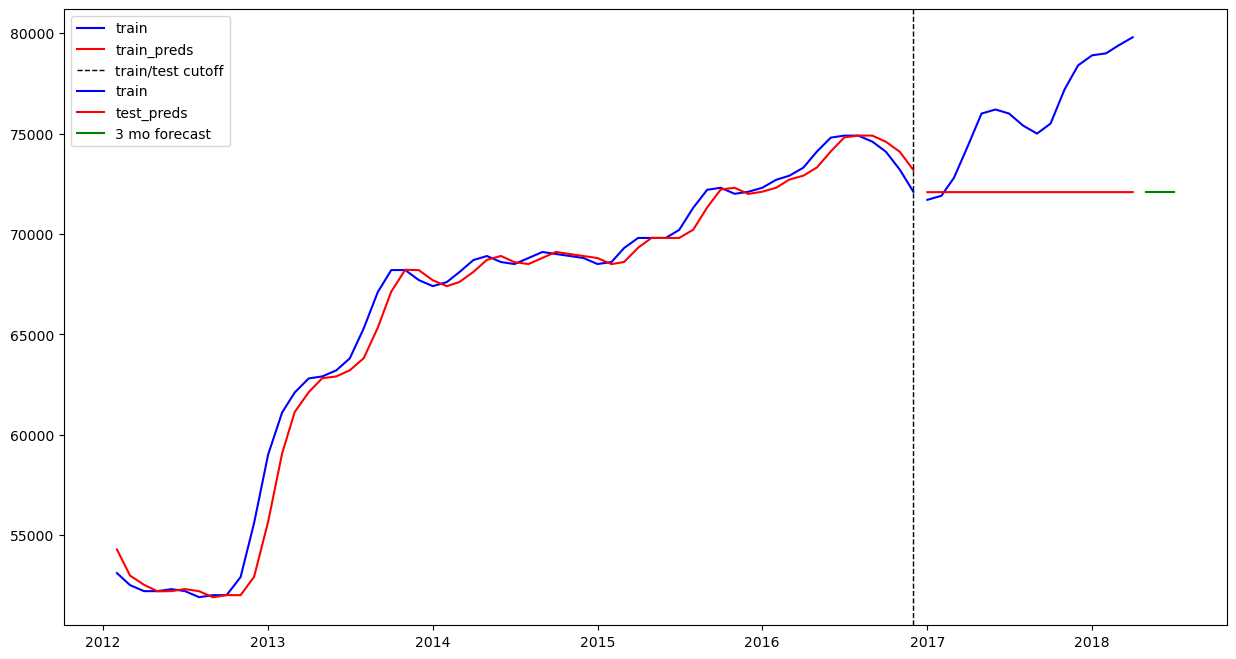

In [384]:
row = tts_arima_model_df.iloc[-1]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(row.train, c='blue', label='train')
ax.plot(row.train_predictions, c='red', label='train_preds')

ax.axvline(datetime.datetime(2016, 12, 1), c='black', linewidth=1, linestyle='--', label='train/test cutoff')

ax.plot(row.test, c='blue', label='train')
ax.plot(row.test_predictions, c='red', label='test_preds')

ax.plot(row.forecast, c='green', label='3 mo forecast')

ax.legend()

In [264]:
tts_arima_model_df.train_mse.mean()

1216349.852256938

In [265]:
tts_arima_model_df.test_mse.mean()

48796055.34805227

In [267]:
tts_arima_model_df.test_mse.mean() / tts_arima_model_df.train_mse.mean()

40.11679309000709

In [275]:
len(tts_arima_model_df.query("test_mse>100000000"))

61

In [276]:
tts_arima_model_df.query("test_mse<100000000").test_mse.mean()

25312772.954852514

# Rolling forecasts

In [314]:
# train.index[-1] + pd.Timedelta(days=30)

# timestamps = list(ad_2012.groupby('time').sum().index[60:])
# timestamps.append(pd.to_datetime('2018/05/01'))
# timestamps.append(pd.to_datetime('2018/06/01'))
# timestamps.append(pd.to_datetime('2018/07/01'))

Timestamp('2016-12-31 00:00:00')

In [354]:
st = time.time()

predictions_list = []
forecasts = []
trains, tests = [], []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    zipcode = ad_2012[ad_2012.zipcode==zc].value
    
    train = zipcode[zipcode.index<'2017-01-01']
    test = zipcode[zipcode.index>'2016-12-01']
    
    trains.append(train[1:])
    tests.append(test)
    
    predictions = model.predict()
    predictions_list.append(predictions[1:])
    
    for x in range(19):
        model = ARIMA(train, order=(1, 1, 1)).fit()
        forecast = model.get_forecast(steps=1).predicted_mean
        train = pd.concat([train, forecast])
        clear_output(wait=True)
        print(f"Zipcode: #{i+1}/{ad_2012.zipcode.nunique()}")
        print(f"Rolling model #{x+1}/{19} done.")
    
    forecast = train[60:]
    forecasts.append(forecast)
    
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode: #453/453
Rolling model #18/19 done.
Execution time: 290.7983920574188 seconds


In [359]:
rolling_arima_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'predictions': predictions_list, 
                               'forecast': forecasts, 
                               'train': trains, 
                               'test': tests})

rolling_arima_df['train_predictions'] = rolling_arima_df.predictions.map(lambda x: x[:59])
rolling_arima_df['test_predictions'] = rolling_arima_df.forecast.map(lambda x: x[:16])

rolling_arima_df['train_mse'] = [mean_squared_error(rolling_arima_df.train.iloc[i], rolling_arima_df.train_predictions.iloc[i]) for i in range(len(rolling_arima_df))]
rolling_arima_df['test_mse'] = [mean_squared_error(rolling_arima_df.test.iloc[i], rolling_arima_df.test_predictions.iloc[i]) for i in range(len(rolling_arima_df))]

rolling_arima_df['forecast'] = rolling_arima_df.forecast.map(lambda x: x[16:])

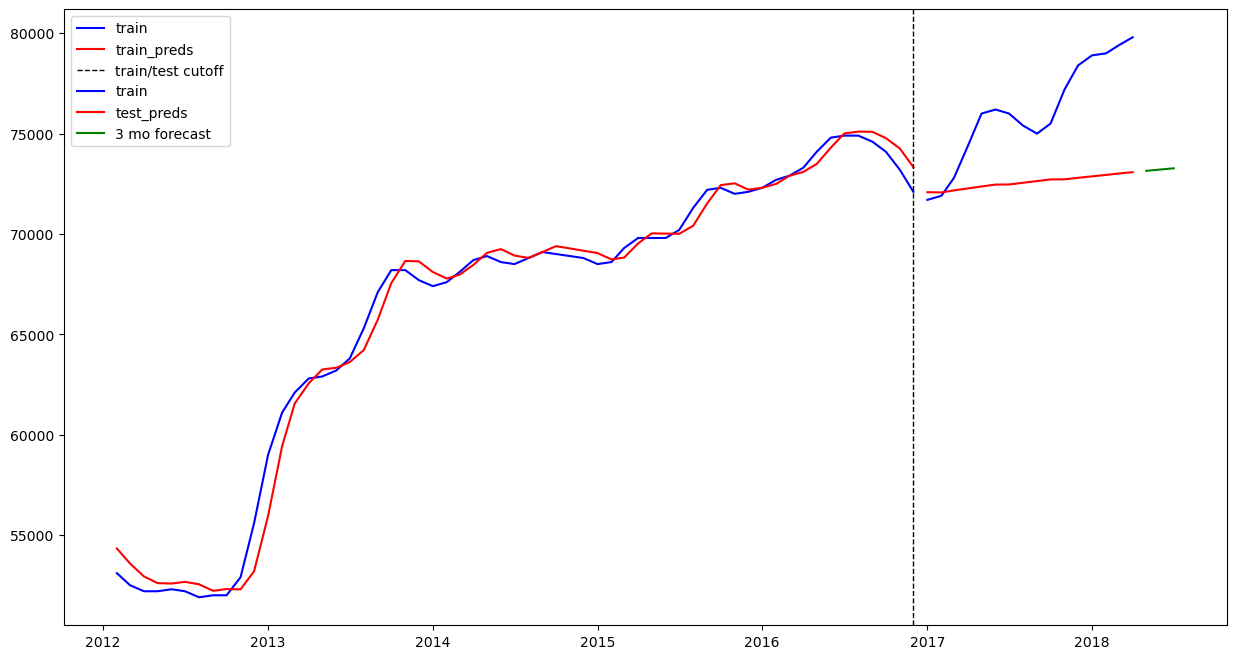

In [389]:
row = rolling_arima_df.iloc[-1]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(row.train, c='blue', label='train')
ax.plot(row.train_predictions, c='red', label='train_preds')

ax.axvline(datetime.datetime(2016, 12, 1), c='black', linewidth=1, linestyle='--', label='train/test cutoff')

ax.plot(row.test, c='blue', label='train')
ax.plot(row.test_predictions, c='red', label='test_preds')

ax.plot(row.forecast, c='green', label='3 mo forecast')

ax.legend()

In [369]:
rolling_arima_df.train_mse.mean()

1172730.0522726274

In [370]:
rolling_arima_df.test_mse.mean()

44522108.44289325

In [371]:
rolling_arima_df.test_mse.mean() / tts_arima_model_df.train_mse.mean()

36.603045053429696

In [372]:
len(rolling_arima_df.query("test_mse>100000000"))

54

In [373]:
rolling_arima_df.query("test_mse<100000000").test_mse.mean()

25738863.342910778

# Rolling ARIMA on just last three forecasts

Now that we've established a rolling ARIMA outperforms a standard ARIMA in terms of overfitting and prediction accuracy, we can use ARIMA on all our available train data and just do the rolling model on the last three forecasts.

In [394]:
st = time.time()

predictions_list = []
forecasts = []
trains = []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    train = ad_2012[ad_2012.zipcode==zc].value
    
    trains.append(train[1:])
    
    model = ARIMA(train, order=(1, 1, 1)).fit()
    predictions = model.predict()
    predictions_list.append(predictions[1:])
    
    for x in range(3):
        model = ARIMA(train, order=(1, 1, 1)).fit()
        forecast = model.get_forecast(steps=1).predicted_mean
        train = pd.concat([train, forecast])
        clear_output(wait=True)
        print(f"Zipcode: #{i+1}/{ad_2012.zipcode.nunique()}")
        print(f"Rolling model #{x+1}/{3} done.")
    
    forecast = train[-3:]
    forecasts.append(forecast)
    
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode: #453/453
Rolling model #3/3 done.
Execution time: 64.41171383857727 seconds


In [396]:
rolling_arima_df_2 = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'predictions': predictions_list, 
                               'forecast': forecasts, 
                               'train': trains})

rolling_arima_df_2['train_mse'] = [mean_squared_error(rolling_arima_df.train.iloc[i], rolling_arima_df.predictions.iloc[i]) for i in range(len(rolling_arima_df))]

<Axes: >

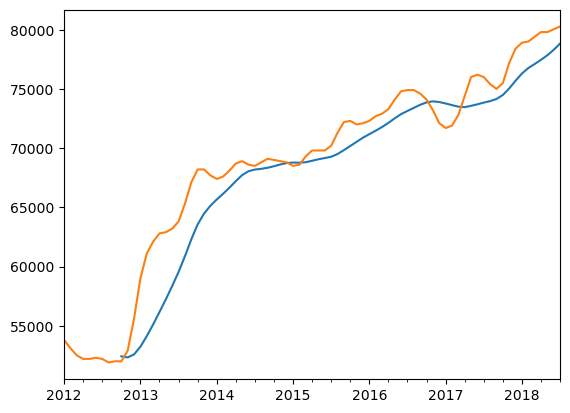

In [411]:
train.rolling(10).mean().plot()
train.plot()

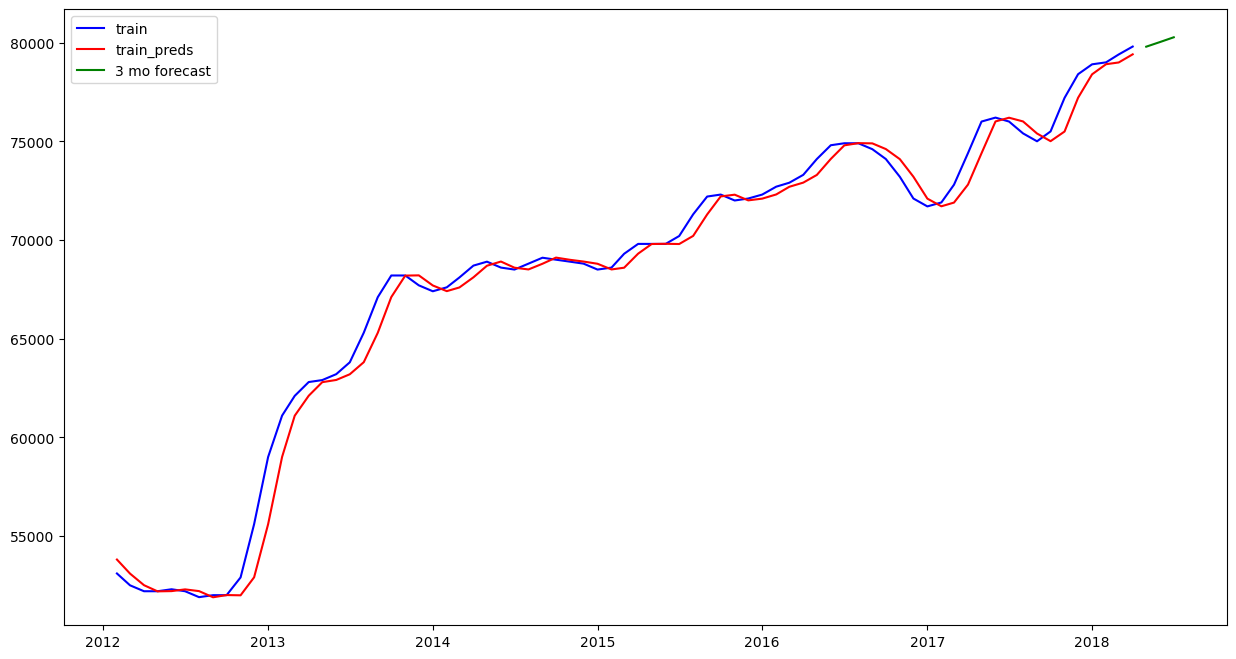

In [401]:
row = rolling_arima_df_2.iloc[-1]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(row.train, c='blue', label='train')
ax.plot(row.predictions, c='red', label='train_preds')

ax.plot(row.forecast, c='green', label='3 mo forecast')

ax.legend()

In [402]:
rolling_arima_df_2.train_mse.mean()

1328207.7942073783

<Axes: >

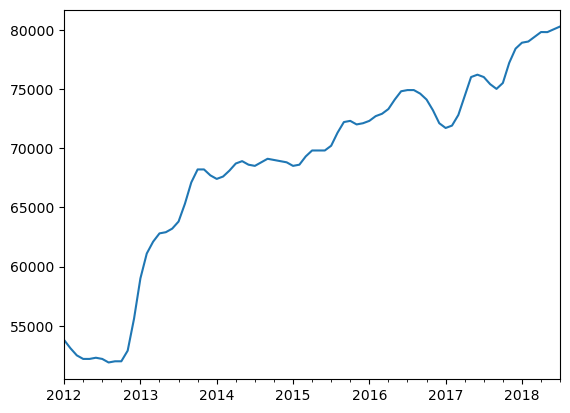

In [412]:
train.plot()

In [415]:
train.diff(1).diff(1).diff(1)

2012-01-01           NaN
2012-02-01           NaN
2012-03-01           NaN
2012-04-01    200.000000
2012-05-01      0.000000
                 ...    
2018-03-01    700.000000
2018-04-01   -300.000000
2018-05-01   -406.077241
2018-06-01    651.417430
2018-07-01   -247.441671
Length: 79, dtype: float64

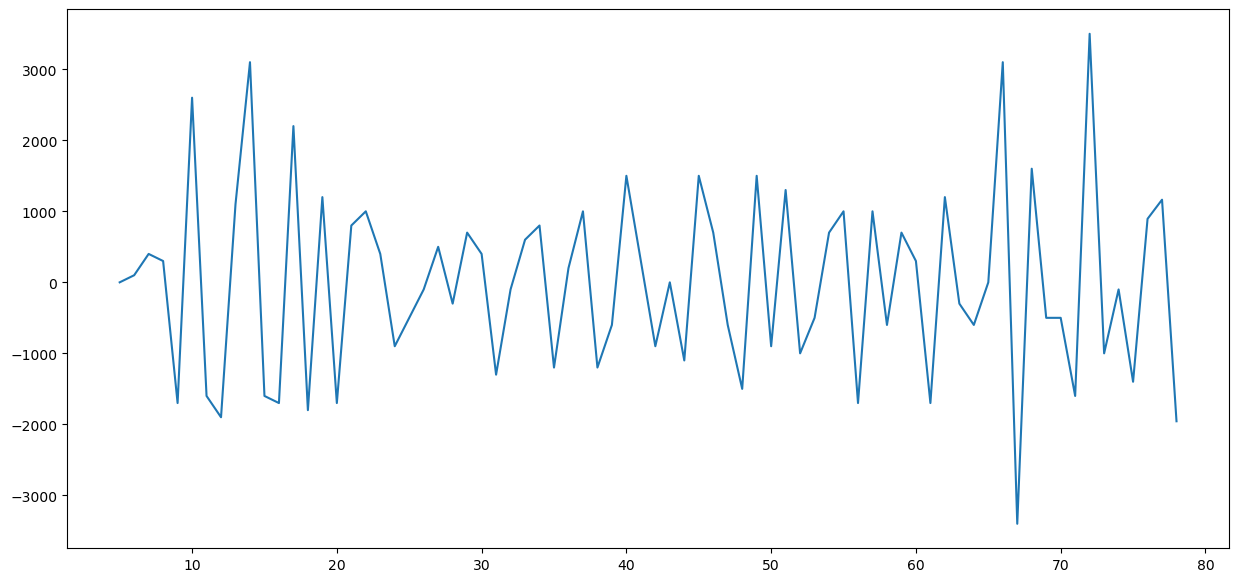

In [433]:
nums = pd.DataFrame({'num': list(range(-100,100)), 'sq': [i**2 for i in list(range(-100,100))]})
nums['diff1'] = nums.sq.diff(1)
nums['diff2'] = nums.diff1.diff(1)

fig, ax = plt.subplots(figsize=(15,7))
# ax.plot(nums.num, nums.sq)
ax.plot(range(len(train)), train.diff(1).diff(1).diff(1).diff(1).diff(1))

In [437]:
percentage_increases = []

for zipcode in ad_2012.zipcode.unique():
    zc = ad_2012[ad_2012.zipcode==zipcode].value
    percentage_increase = (zc.iloc[-1] / zc.iloc[0])
    percentage_increases.append(percentage_increase)

increases = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 'percentage_increase': percentage_increases})

9.153241911862601


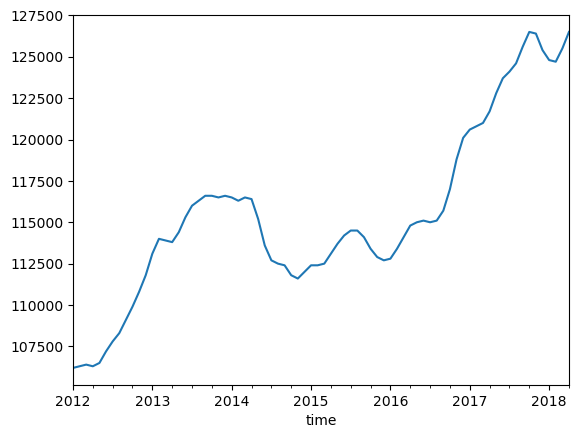

In [499]:
zipcode = 48603
ad_2012[ad_2012.zipcode==zipcode].value.plot()
print(volatility_score(zipcode))

In [700]:
def volatility_score(lst):
    series = pd.Series(lst)
    differences = series.diff(1).diff(1)
    squared_differences = differences.map(lambda x: x**2)
    mean_squared_difference = squared_differences.mean()
    rng = series.max() - series.min()
    return (mean_squared_difference/(rng**2)) * len(series)

In [701]:
# def volatility_score(lst):
#     series = pd.Series(lst)
#     differences = series.diff(1)
#     rng = series.max() - series.min()
#     pct = differences.map(lambda x: np.abs(x/rng))
#     return pct.mean()

In [702]:
volatilities = pd.DataFrame({'zipcode': ad_2012.zipcode.unique()})
volatilities['volatility'] = volatilities.zipcode.map(lambda x: volatility_score(ad_2012[ad_2012.zipcode==x].value))

In [703]:
volatilities.sort_values(by='volatility')

,zipcode,volatility
118,49428,1.062692
3,48185,1.086344
53,49505,1.137482
81,48080,1.261749
23,49504,1.310345
...,...,...
448,49322,51.082158
443,48897,51.574206
447,49102,73.281053
418,49060,83.390385


<Axes: xlabel='time'>

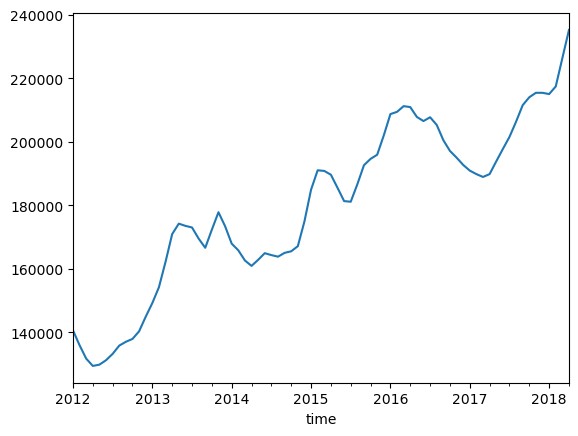

In [710]:
ad_2012[ad_2012.zipcode==49060].value.plot()